In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('dailydataprice.csv', delimiter=",", encoding='latin-1', usecols=['Date', 'Price'])
df.head()


,Date,Price
0,4-Jan-00,84.37
1,5-Jan-00,85.54
2,6-Jan-00,84.77
3,7-Jan-00,82.64
4,10-Jan-00,84.69


In [2]:
dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07',  'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
for key, value in dict.items():
  df['Date'] = df['Date'].str.replace(key, value)

In [3]:
print(df.dtypes)

Date      object
Price    float64
dtype: object


In [4]:
df.columns =['Date', 'Price']
df.head()

,Date,Price
0,4-01-00,84.37
1,5-01-00,85.54
2,6-01-00,84.77
3,7-01-00,82.64
4,10-01-00,84.69


In [5]:
grouped_df = df.groupby('Date').Price.sum()
grouped_df

Date
1-02-00     78.48
1-02-01     49.11
1-02-02     42.64
1-02-05     82.34
1-02-06    101.52
            ...  
9-12-14    154.39
9-12-15    117.14
9-12-16    129.64
9-12-19    117.10
9-12-20    110.35
Name: Price, Length: 5379, dtype: float64

In [6]:
df = pd.DataFrame(grouped_df)
df = df.reset_index() # đoạn này có fix

In [7]:
print(df.dtypes)
print(df)

Date      object
Price    float64
dtype: object
         Date   Price
0     1-02-00   78.48
1     1-02-01   49.11
2     1-02-02   42.64
3     1-02-05   82.34
4     1-02-06  101.52
...       ...     ...
5374  9-12-14  154.39
5375  9-12-15  117.14
5376  9-12-16  129.64
5377  9-12-19  117.10
5378  9-12-20  110.35

[5379 rows x 2 columns]


In [8]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
print(df.dtypes)

# Cột này để chuyển lại qua date time, để sau này t extract

Date     datetime64[ns]
Price           float64
dtype: object


C:\Users\Vũ Hoàng Tùng\AppData\Local\Temp\ipykernel_15868\4239663659.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [50]:
import matplotlib.pyplot as plt

def showdata(data, start=0, end=None):
    if end is None:
        end = len(data)  

    # Slice data
    sliced_data = data.iloc[start:end]

    col = [
           # "Lag1", 
          # "Lag2", 
        #   "Lag3", 
        #  "Lag365", 
           "MeanWeek", 
           "MeanMonth",
           "Price"
           ]

    col = [col for col in col if col in sliced_data.columns]

    if not col:
        print("No matching columns found in the dataset.")
        return

    plt.figure(figsize=(12, 6))

    for column in col:
        plt.plot(sliced_data['Date'], sliced_data[column], label=column)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Data Trend from {start} to {end}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()


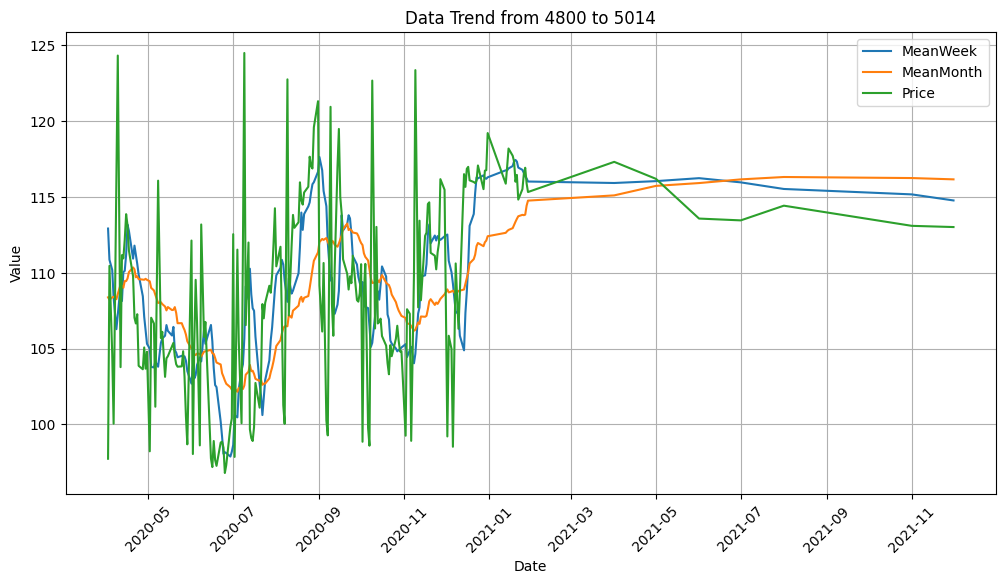

In [55]:
showdata(df,4800,5014)

Feature Extraction

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso,LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

df["Date"] = pd.to_datetime(df["Date"])

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.weekday

# Này là xem giá buổi trc để đoán giá buổi sau, m muốn tháng trc thì shift 30
df["Lag1"] = df["Price"].shift(1)
df["Lag2"] = df["Price"].shift(2)
df["Lag3"] = df["Price"].shift(3)

df["Lag365"] = df["Price"].shift(365)

df["MeanWeek"] = df["Price"].rolling(window=7).mean().shift(1)  # Mean of last 7 days
df["MeanMonth"] = df["Price"].rolling(window=30).mean().shift(1)  # Mean of last 30 days
df.dropna(inplace=True)

# Tách ra số cụ thể ngày tháng năm, nếu thấy nhiều noise quá có thể comment
X = df[[
        "Year" 
        , "Month"
        , "Day"
        , "DayOfWeek"
        , "Lag1"
        , "Lag2"
        , "Lag3"
        , "Lag365"
        , "MeanWeek"
        , "MeanMonth"]]
y = df["Price"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)  # No shuffle for time series



In [12]:
mse = []
rmse = []
r2 = []
accuracy = []

In [13]:
import optuna

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }
    
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)



C:\Users\Vũ Hoàng Tùng\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-13 22:21:37,957] A new study created in memory with name: no-name-56f7abf6-4a6b-486c-8a48-e01b1b89eaa8
[I 2025-03-13 22:21:38,465] Trial 0 finished with value: 63.23225288703966 and parameters: {'learning_rate': 0.17331207923004727, 'n_estimators': 182, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 9, 'subsample': 0.9959920037027363, 'max_features': 'log2'}. Best is trial 0 with value: 63.23225288703966.
[W 2025-03-13 22:21:41,381] Trial 1 failed with parameters: {'learning_rate': 0.167964001142914, 'n_estimators': 808, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 4, 'subsample': 0.8373491332679535, 'max_features': 'log2'} because of the following error: KeyboardInterrupt().

KeyboardInterrupt: 

In [ ]:
import optuna

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  
        "gamma": trial.suggest_float("gamma", 0, 10), 
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 10.0, log=True),  
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 10.0, log=True),  
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),  
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  

study.best_trial.params


In [15]:
study.best_trial.params


{'learning_rate': 0.1991606286294636,
 'n_estimators': 989,
 'max_depth': 4,
 'subsample': 0.7795801971692902,
 'colsample_bytree': 0.8831873249435928,
 'gamma': 8.834335825667878,
 'reg_alpha': 8.504870973664653,
 'reg_lambda': 8.45401578308365,
 'min_child_weight': 10,
 'booster': 'gblinear'}

In [15]:
rf = RandomForestRegressor()

gb = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=10,
    min_samples_split=20,
    n_estimators=100,
    subsample=0.9
)
xgb = XGBRegressor(
    learning_rate= 0.1991606286294636,
    n_estimators= 989,
    max_depth= 4,
    subsample= 0.7795801971692902,
    colsample_bytree= 0.8831873249435928,
    gamma= 8.834335825667878,
    reg_alpha= 8.504870973664653,
    reg_lambda= 8.45401578308365,
    min_child_weight= 10,
    booster= 'gblinear'
)



In [27]:
# Meta-Learner (Final Estimator)
meta_learner = LassoCV(cv=10)

# Stacking Regressor
stacking_model = StackingRegressor(estimators=[ ("gb", gb),("xgb", xgb)], final_estimator=meta_learner, cv=10 )

# Train Model
stacking_model.fit(X_train, y_train)

# Predictions
y_pred = stacking_model.predict(X_test)

C:\Users\Vũ Hoàng Tùng\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Vũ Hoàng Tùng\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Vũ Hoàng Tùng\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc033

Evaluate

Compare to base model

In [28]:
gb.fit(X_train, y_train)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)

# Compute R² Scores
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100

rf_accuracy = 100 - rf_mape

print(f"Mean Squared Error of RFR: {rf_mse:.4f}")
print(f"R² Score of RFR: {rf_r2:.4f}")
print(f"Regression Accuracy of RFR: {rf_accuracy:.2f}%")

gb_mse = mean_squared_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

gb_mape = np.mean(np.abs((y_test - gb_pred) / y_test)) * 100

gb_accuracy = 100 - gb_mape

print(f"Mean Squared Error of GBR: {gb_mse:.4f}")
print(f"R² Score of GBR: {gb_r2:.4f}")
print(f"Regression Accuracy of GBR: {gb_accuracy:.2f}%")

Mean Squared Error of RFR: 38.0329
R² Score of RFR: 0.6584
Regression Accuracy of RFR: 95.79%
Mean Squared Error of GBR: 29.3593
R² Score of GBR: 0.7363
Regression Accuracy of GBR: 96.33%


In [29]:
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

# Compute R² Scores
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

xgb_mape = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100

xgb_accuracy = 100 - xgb_mape

print(f"Mean Squared Error of XGBR: {xgb_mse:.4f}")
print(f"R² Score of XGBR: {xgb_r2:.4f}")
print(f"Regression Accuracy of XGBR: {xgb_accuracy:.2f}%")

C:\Users\Vũ Hoàng Tùng\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error of XGBR: 24.5286
R² Score of XGBR: 0.7797
Regression Accuracy of XGBR: 96.88%


In [30]:
def weighted_ensemble_predict(X, gb_model, xgb_model, weight_gb=0.5, weight_xgb=0.5):
    gb_pred = gb_model.predict(X)
    xgb_pred = xgb_model.predict(X)
    return (weight_gb * gb_pred) + (weight_xgb * xgb_pred)

gb.fit(X_train, y_train)
xgb.fit(X_train, y_train)

y_pred1 = weighted_ensemble_predict(X_test, gb, xgb, weight_gb=0.1, weight_xgb=0.9)


C:\Users\Vũ Hoàng Tùng\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


In [31]:
mse1 =(mean_squared_error(y_test, y_pred1))
rmse1 =np.sqrt(mean_squared_error(y_test, y_pred1))
r2_1 =(r2_score(y_test, y_pred1))

mape = np.mean(np.abs((y_test - y_pred1) / y_test)) * 100

accuracy1 = ( 100 - mape)
print(f"Mean Squared Error: {mse1:.4f}")
print(f"R² Score: {r2_1:.4f}")
print(f"Regression Accuracy: {accuracy1:.2f}%")

Mean Squared Error: 24.2905
R² Score: 0.7818
Regression Accuracy: 96.86%


In [32]:
mse.append(mean_squared_error(y_test, y_pred))
rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
r2.append(r2_score(y_test, y_pred))

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

accuracy.append( 100 - mape)
print(f"Mean Squared Error: {mse[0]:.4f}")
print(f"R² Score: {r2[0]:.4f}")
print(f"Regression Accuracy: {accuracy[0]:.2f}%")
# --- Random Forest (RF) ---
mse.append(rf_mse)
rmse.append(np.sqrt(rf_mse))
r2.append(rf_r2)
accuracy.append(rf_accuracy)

# --- Gradient Boosting (GB) ---
mse.append(gb_mse)
rmse.append(np.sqrt(gb_mse))
r2.append(gb_r2)
accuracy.append(gb_accuracy)

# --- XGBoost (XGB) ---

mse.append(xgb_mse)
rmse.append(np.sqrt(xgb_mse))
r2.append(xgb_r2)
accuracy.append(xgb_accuracy)

Mean Squared Error: 24.7161
R² Score: 0.7780
Regression Accuracy: 96.90%


In [ ]:
models = ["Stack","Random Forest", "Gradient Boosting", "XGBoost"]
results_df = pd.DataFrame({
    "Model": models,
    "MSE": mse,
    "RMSE": rmse,
    "R² Score": r2,
    "Accuracy (%)": accuracy
})

print(results_df)


               Model         MSE       RMSE  R² Score  Accuracy (%)
0              Stack   43.623882   6.604838  0.608206     95.442931
1      Random Forest   57.820070   7.603951  0.480708     94.591199
2  Gradient Boosting   60.911662   7.804592  0.452942     94.164032
3            XGBoost  335.923776  18.328223 -2.016989     85.711926


In [40]:
print(accuracy)
print(rmse)
print(mse)
print(r2)

[np.float64(95.4429308850017), np.float64(94.5911987932173), np.float64(94.16403193298608), np.float64(85.71192625497767), np.float64(94.5911987932173), np.float64(94.16403193298608), np.float64(85.71192625497767), np.float64(94.5911987932173), np.float64(94.16403193298608), np.float64(85.71192625497767)]
[np.float64(6.604837776133921), np.float64(7.603950971189477), np.float64(7.804592334846149), np.float64(18.328223482699613), np.float64(7.603950971189477), np.float64(7.804592334846149), np.float64(18.328223482699613), np.float64(7.603950971189477), np.float64(7.804592334846149), np.float64(18.328223482699613)]
[43.62388204904568, 57.82007037225339, 60.91166151313926, 335.9237760317815, 57.82007037225339, 60.91166151313926, 335.9237760317815, 57.82007037225339, 60.91166151313926, 335.9237760317815]
[0.6082064937072815, 0.4807081112183491, 0.45294200521821426, -2.016988582323125, 0.4807081112183491, 0.45294200521821426, -2.016988582323125, 0.4807081112183491, 0.45294200521821426, -2.0

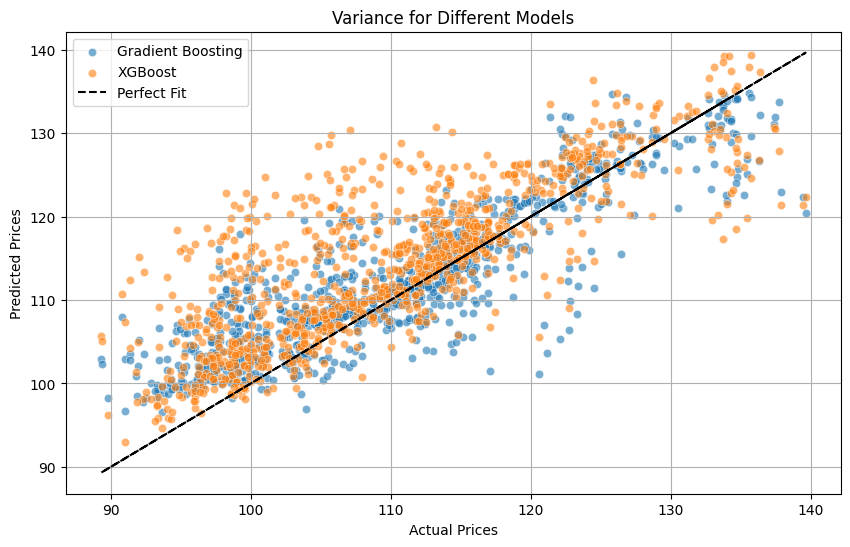

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot for each model
plt.figure(figsize=(10, 6))

# Scatter for each model (Replace with your actual predictions)
# sns.scatterplot(x=y_test, y=rf_pred, label="Random Forest", alpha=0.6)
sns.scatterplot(x=y_test, y=gb_pred, label="Gradient Boosting", alpha=0.6)
sns.scatterplot(x=y_test, y=xgb_pred, label="XGBoost", alpha=0.6)
# sns.scatterplot(x=y_test, y=y_pred, label="Stacking Model", alpha=0.8, marker="x", color="red")

# Plot a reference line (Perfect Predictions)
plt.plot(y_test, y_test, color="black", linestyle="dashed", label="Perfect Fit")

# Labels & Legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Variance for Different Models")
plt.legend()
plt.grid(True)

plt.show()
